# THIS PART WAS USE TEST THE CLASSIFIERS AND BUILD THE FEATURES

# A. Start

## A.1. Different imports

In [1]:
import glob
import os
import io

import networkx as nx
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import average_precision_score, f1_score


# For embeddings (graph/text)
from node2vec.node2vec import Node2Vec
import gensim
import spacy
from scipy.spatial.distance import cosine
import scipy

## A.2. Data paths and filenames

In [48]:
train_file = './data/training.txt'
texts_path_abs = './data/node_information/text'
test_file = './data/testing.txt'
out_file = 'out.csv'
#tobetranslated_file='tobetranslated.txt'
#translated_file='translated.txt'

file_umap='umap_with_nc_equal'
file_node_vecs = 'node2vec.model'
file_text_vecs = 'word2vec_300.kv'
file_language='languages.txt'

## A.3. Parameters

In [13]:
# Graph model
directed = False

# Overwrite existing embeddings (if True computes all embeddings again during ~20h)
overwrite_nodes = True
overwrite_text = True
overwrite_umap = True
language_overwrite=True
overwrite_translation=True


language_load = False
load_nodes = False
load_text = False
load_umap = False
load_translated_version=False

#Umap embedding
nc=3

# node2vec embeddings
dimensions = 128
walk_length = 100
num_walks = 50
workers = 3

# database for classification training
prop_split = 0.10
random_state = 42

## A.4. Build Graph

In [4]:
toy = False # Set to true for debug, faster run
it_toy_limit = 1000
it = 0
# First read and create the graph using the training dataset
G = nx.Graph()
DG = nx.DiGraph()
with open("training.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        if line[2] == "1":
            G.add_edge(line[0], line[1])
            DG.add_edge(line[0], line[1])
            it += 1
            if toy and it >= it_toy_limit:
                break
        if line[2] == "0":
            G.add_node(line[0])
            G.add_node(line[1])
            DG.add_node(line[0])
            DG.add_node(line[1])

453797it [00:03, 141347.72it/s]


In [5]:
def info(graph):
    """
    Prints some basic statistics of a graph
    """
    print('Type:', 'Directed' if isinstance(graph, nx.DiGraph) else 'Undirected')
    n = graph.number_of_nodes()
    e = graph.number_of_edges()
    print('Nodes:', n)
    print('Edges:', e)
    if not isinstance(graph, nx.DiGraph):
        print('Connected components:', nx.algorithms.components.number_connected_components(graph))
    degrees = graph.degree()
    sum_of_edges = sum([d[1] for d in degrees])
    print('Mean degree:', sum_of_edges // n)

In [6]:
info(G)

Type: Undirected
Nodes: 33226
Edges: 283623
Connected components: 67
Mean degree: 17


In [7]:
info(DG)

Type: Directed
Nodes: 33226
Edges: 283623
Mean degree: 17


# B. BUILD (AND SAVE) MORE COMPLICATED FEATURES FOR THE NODES

## B.1. Create vector X (Node 1 - Node 2) and y (Linked ?) on training.txt

In [8]:
X = []
y = []
add_sym = True # Set to true if you want to had symetrical data non present in G
add_sym2= False # If True, the results are poorer

it = 0
with open("training.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        n1, n2 = line[0], line[1]
        X.append([n1,n2])

        if line[2] == "1":
            y.append(1.0)
        
            it += 1
            if toy and it >= it_toy_limit:
                break
                
            if add_sym2 and not(DG.has_edge(n2,n1)):
                X.append([n2,n1])
                y.append(0.0)
            
        else:
            y.append(0.0)
                  
        if add_sym and not(G.has_edge(n2, n1)):
            X.append([n2,n1])
            y.append(0.0)
                          
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y, axis=1)

453797it [00:02, 191400.62it/s]


In [9]:
print("shape X: ", np.shape(X))
print("shape y: ", np.shape(y))

shape X:  (623940, 2)
shape y:  (623940, 1)


## B.2. Build Eigenmap on the Normalized Laplacian Matrix
DO NOT EXECUTE B.2: IT DOES NOT WORK IS NOT NOT NEEDED

In [10]:
#LN=nx.normalized_laplacian_matrix(G)
#L=nx.directed_laplacian_matrix(DG) Ne marche pas : je n'ai pas la puissance nécessaire

In [11]:
#w,v=scipy.sparse.linalg.eigs(LN)

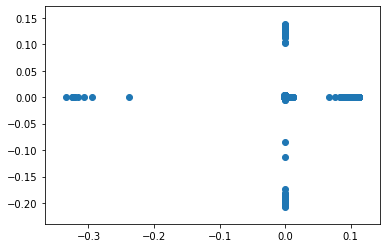

In [12]:
Node_normlap=v.real @ np.diag((w.real)**0.5)
plt.scatter(Node_normlap[:, 3], Node_normlap[:, 5])
plt.show()

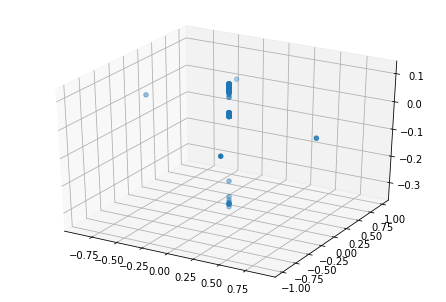

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
xs = Node_normlap[:, 1]
ys = Node_normlap[:, 2]
zs = Node_normlap[:, 3]
ax = ax = Axes3D(fig)
ax.scatter(xs, ys, zs)
plt.show()

This feature from the normalized laplacian matrix doesn't give good results : there are too many big eigenvalues and we can not do a proper approximation of the matrix only with a few dimensions that way. Hence, the results are not stored.

## B.3. Build UMAP on the Adjency matrix and save it

In [11]:
A = nx.adjacency_matrix(G)
print("shape Adjacency matrix A: ", np.shape(A))
nid_to_index = {nid:i for i, nid in enumerate(G.nodes)}

shape Adjacency matrix A:  (33226, 33226)


In [14]:
if overwrite_umap:
    import umap
    reducer = umap.UMAP(verbose=True,random_state=random_state,n_components=nc)
    Node_umap = reducer.fit_transform(A)
else:
    print('Change overwrite_umap to True to compute and save Umap embedding') 

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Dec 30 15:14:24 2019 Finding Nearest Neighbors
Mon Dec 30 15:14:24 2019 Building RP forest with 14 trees
Mon Dec 30 15:15:39 2019 NN descent for 15 iterations


C:\Users\cedri\Anaconda3\lib\site-packages\umap\sparse.py:247: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "Anaconda3\lib\site-packages\umap\utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
C:\Users\cedri\Anaconda3\lib\site-packages\numba\compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "Anaconda3\lib\site-packages\umap\sparse.py", line 176:
    @nu

	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Mon Dec 30 15:16:56 2019 Finished Nearest Neighbor Search
Mon Dec 30 15:16:59 2019 Construct embedding


C:\Users\cedri\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Dec 30 15:18:28 2019 Finished embedding


In [15]:
if overwrite_umap:
    print(np.shape(Node_umap))
else:
    print('Change overwrite_umap to True to compute and save Umap embedding') 

(33226, 3)


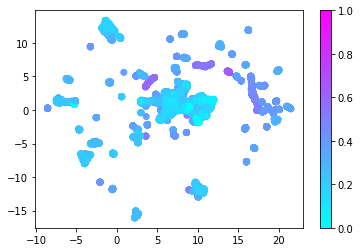

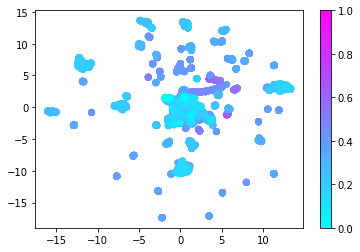

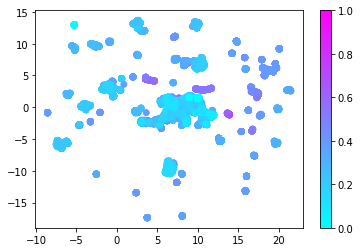

In [16]:
if overwrite_umap:
    N = G.number_of_nodes()
    max_degree = max([d[1] for d in G.degree()])
    c = [np.log(d[1])/np.log(max_degree) if d[1] > 0 else 0 for d in G.degree()]
    cmap = plt.get_cmap('cool')
    plt.scatter(Node_umap[:, 0], Node_umap[:, 1], c=c, cmap=cmap)
    plt.colorbar()
    plt.show()

    plt.scatter(Node_umap[:, 1], Node_umap[:, 2], c=c, cmap=cmap)
    plt.colorbar()
    plt.show()

    plt.scatter(Node_umap[:, 0], Node_umap[:, 2], c=c, cmap=cmap)
    plt.colorbar()
    plt.show()
else:
    print('Change overwrite_umap to True to compute and save Umap embedding') 

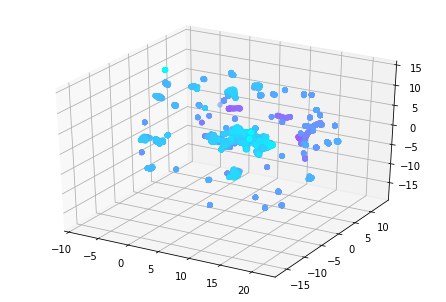

In [17]:
if overwrite_umap:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    xs = Node_umap[:, 0]
    ys = Node_umap[:, 1]
    zs = Node_umap[:, 2]
    ax = ax = Axes3D(fig)
    ax.scatter(xs, ys, zs, c=c, cmap=cmap)
    plt.show()

else:
    print('Change overwrite_umap to True to compute and save Umap embedding') 

In [18]:
# Save Umap model
if overwrite_umap:
    print('Saving Umap embeddings')
    with open('./embeddings/' + file_umap+str(nc)+'.model', 'a') as savefile:
        savefile.write(str(np.shape(Node_umap)[0]) + ' '+str(nc) + '\n')
        it=0
       
        for f in tqdm(Node_umap):
            savefile.write(str(it)+' ')
            it=it+1
            for i in range(Node_umap.shape[1]):
                savefile.write(str(f[i]) + ' ')
            savefile.write('\n')
    savefile.close
else:
    print('Change overwrite_umap to True to compute and save Umap embedding')

Saving Umap embeddings


100%|██████████| 33226/33226 [00:00<00:00, 117233.13it/s]


## B.4.Jacquart coeff

In [19]:
def get_jc(G, n1, n2):
    try:
        coef = [
            [u, v, p] for u, v, p in nx.jaccard_coefficient(G, [(n1, n2)])
        ][0]
        return coef[2]
    except:
        return 0.0

## B.5. Build Node2Vec embedding

Trained on our graph. source : https://github.com/eliorc/node2vec

In [20]:
# Initalize model & probs
if overwrite_nodes:
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
else:
    print('Change overwrite_nodes to True to initialize Node2Vec')

Computing transition probabilities:   1%|          | 354/33226 [00:22<34:09, 16.04it/s]  

KeyboardInterrupt: 

In [18]:
# Compute embeddings
if overwrite_nodes:
    embeddings = node2vec.fit()
else:
    print('Change overwrite_nodes to True to fit Node2Vec')

Change overwrite_nodes to True to fit Node2Vec


In [19]:
# Save embeddings
if overwrite_nodes:
    filename = fname(['node2vec', dimensions, walk_length, num_walks], '.kv')
    embeddings.wv.save_word2vec_format('./embeddings/' + filename)
else:
    print('Change overwrite_nodes to True to save Node2Vec')

Change overwrite_nodes to True to save Node2Vec


# C. BUILD FEATURE FOR THE TEXT

## C.1. Very simple feature : size of the document

In [21]:
import numpy as np
from scipy import *
G.number_of_nodes()
File_size=zeros(G.number_of_nodes())
text_files = glob.glob(texts_path_abs + '/*.txt')

In [22]:
File_size=zeros(G.number_of_nodes())
it=0
for f in tqdm(text_files):
    it=it+1
    taille=len(f)
    numero=int(f[79:taille-4])
    taille_fichier=os.path.getsize(f)
    File_size[numero]=log(1+taille_fichier)
print('Size of',it,'text files loaded')


100%|██████████| 33214/33214 [00:07<00:00, 4224.89it/s]

Size of 33214 text files loaded


## C.2. Preprocessing : deal with the language issue

A basic look at the texts shows that there are two issues than need to be dealt with before we try to lean something about the texts:
- More than a third of the website are not in French -> ideally we want to translate everything in French before we run the algorithms to calculate distances between the documents (but that is quite complicated to do in practice). At least, we need to know the language.
- Some of the website have special caracters and some not (Ex : 2.txt = "   En poursuivant votre navigation sur ce site, vous acceptez que nous utilisions des cookies pour mesurer l'audience de nos sites et pour vous proposer des fonctionnalités sociales..." whereas 105.txt = "   Retour Ã  la page d'accueil   Suivez-nous sur les rÃ©seaux sociaux -      * Dans le catalogue      * Au cÅur des livres    Recherche avancÃ©e"

In [23]:
from langdetect import detect

In [24]:
if language_overwrite:
    File_lang=[]
    it=-1
    for f in tqdm(text_files):
        it=it+1
        taille=len(f)
        numero=int(f[79:taille-4])
        with io.open(f, 'r', encoding='utf-8') as file:
            try:
                text = file.read()
                lang=detect(text[0:10000]) # We suppose that 10 000 caracters is enough to detect the language
                File_lang.append([numero,lang])
            
            except:
                File_lang.append([numero,'Empty'])
                continue
    File_lang=np.array(File_lang)
    Languages_list=list(set(File_lang[:,1]))
else:
    print('Change variable language_ovewrite to run that sequence')


  2%|▏         | 501/33214 [00:21<19:15, 28.32it/s]


  3%|▎         | 1071/33214 [00:41<17:29, 30.64it/s]


  5%|▌         | 1694/33214 [01:01<18:36, 28.24it/s]


  7%|▋         | 2282/33214 [01:21<20:56, 24.61it/s]


  9%|▊         | 2858/33214 [01:40<15:26, 32.77it/s]


 10%|█         | 3394/33214 [02:01<19:37, 25.32it/s]


 12%|█▏        | 3972/33214 [02:21<19:54, 24.48it/s]


 14%|█▍        | 4567/33214 [02:40<17:02, 28.02it/s]


 16%|█▌        | 5150/33214 [03:01<14:19, 32.64it/s]


 17%|█▋        | 5675/33214 [03:21<16:26, 27.90it/s]


 19%|█▊        | 6203/33214 [03:41<17:07, 26.29it/s]


 20%|██        | 6761/33214 [04:01<19:50, 22.23it/s]


 22%|██▏       | 7281/33214 [04:22<17:14, 25.07it/s]


 23%|██▎       | 7803/33214 [04:43<22:46, 18.59it/s]


 25%|██▌       | 8352/33214 [05:03<18:27, 22.45it/s]


 27%|██▋       | 8907/33214 [05:23<15:34, 26.02it/s]


 29%|██▊       | 9489/33214 [05:43<11:32, 34.27it/s]


 30%|███       | 10043/33214 [06:03<14:07, 27.35it/s]


 32%|███▏      | 10575/33214 [06:22<13:54, 27.14it/s]


 34%|███▎      | 11157/33214 [06:42<13:06, 28.03it/s]


 35%|███▌      | 11739/33214 [07:02<12:33, 28.50it/s]


 37%|███▋      | 12295/33214 [07:21<17:16, 20.18it/s]


 39%|███▊      | 12807/33214 [07:41<11:27, 29.70it/s]


 40%|████      | 13312/33214 [08:01<13:35, 24.42it/s]


 42%|████▏     | 13810/33214 [08:20<12:44, 25.39it/s]


 43%|████▎     | 14347/33214 [08:41<13:13, 23.78it/s]


 45%|████▍     | 14895/33214 [09:00<12:14, 24.93it/s]


 46%|████▋     | 15409/33214 [09:20<10:28, 28.32it/s]


 48%|████▊     | 15917/33214 [09:39<10:39, 27.03it/s]


 50%|████▉     | 16459/33214 [09:59<11:39, 23.94it/s]


 51%|█████     | 16956/33214 [10:19<09:28, 28.61it/s]


 52%|█████▏    | 17410/33214 [10:39<08:45, 30.08it/s]


 54%|█████▍    | 17921/33214 [10:58<11:52, 21.45it/s]


 56%|█████▌    | 18434/33214 [11:18<11:39, 21.13it/s]


 57%|█████▋    | 18942/33214 [11:37<15:19, 15.52it/s]


 58%|█████▊    | 19398/33214 [11:58<09:08, 25.18it/s]


 60%|█████▉    | 19884/33214 [12:17<09:08, 24.32it/s]


 61%|██████▏   | 20425/33214 [12:38<09:58, 21.35it/s]


 63%|██████▎   | 20968/33214 [12:57<08:15, 24.70it/s]


 65%|██████▍   | 21449/33214 [13:18<07:43, 25.39it/s]


 66%|██████▌   | 21981/33214 [13:38<11:12, 16.70it/s]


 68%|██████▊   | 22488/33214 [13:58<06:39, 26.85it/s]


 69%|██████▉   | 23012/33214 [14:18<05:51, 29.01it/s]


 71%|███████   | 23565/33214 [14:37<05:56, 27.05it/s]


 73%|███████▎  | 24096/33214 [14:56<04:57, 30.63it/s]


 74%|███████▍  | 24675/33214 [15:16<04:25, 32.13it/s]


 76%|███████▌  | 25300/33214 [15:36<04:20, 30.40it/s]


 78%|███████▊  | 25813/33214 [15:56<05:59, 20.57it/s]


 79%|███████▉  | 26321/33214 [16:16<04:55, 23.32it/s]


 81%|████████  | 26813/33214 [16:36<05:44, 18.56it/s]


 82%|████████▏ | 27271/33214 [16:57<04:11, 23.63it/s]


 84%|████████▎ | 27792/33214 [17:18<03:14, 27.94it/s]


 85%|████████▌ | 28341/33214 [17:38<02:25, 33.60it/s]


 87%|████████▋ | 28871/33214 [17:57<02:36, 27.70it/s]


 88%|████████▊ | 29365/33214 [18:18<03:06, 20.69it/s]


 90%|████████▉ | 29860/33214 [18:38<02:12, 25.30it/s]


 91%|█████████▏| 30379/33214 [18:59<02:20, 20.19it/s]


 93%|█████████▎| 30893/33214 [19:19<01:21, 28.56it/s]


 95%|█████████▍| 31402/33214 [19:38<01:22, 22.07it/s]


 96%|█████████▌| 31925/33214 [19:57<00:53, 24.01it/s]


 98%|█████████▊| 32423/33214 [20:17<00:30, 25.72it/s]


 99%|█████████▉| 32916/33214 [20:38<00:15, 19.67it/s]


100%|██████████| 33214/33214 [20:50<00:00, 22.16it/s]

After that, we will 2 datastructures :
- File_lang is 2 Dim array, each data being a number (ex : 10001 for 10001.txt) and its language
- Languages_list is the list (without dooble count) of all avalaible languagues

In [26]:
# SAVE Languages of the differents sites (it is slow to calculate)
if language_overwrite:
    savefile=open('./embeddings/'+file_language, 'w')
    savefile.write(str(len(Languages_list))+' '+str(File_lang.shape[0])+'\n')
    for lang in Languages_list:
        savefile.write(lang+' ')
    savefile.write('\n')
    for i in range (File_lang.shape[0]):
        savefile.write(File_lang[i,0]+' '+File_lang[i,1]+'\n')
    savefile.close()
else:
    print('Change variable language_ovewrite to run that sequence')

In [27]:
# LOAD PREVIOUSLY COMPUTED LANGUAGUES OF THE FILES
if language_load:
    Languages_list=[]
    File_lang=[]
    file=open('./embeddings/'+file_language, 'r')
    line= file.readline()
    line=line.split()
    nextline= file.readline()
    Languages_list=nextline.split()
    for i in range (int(line[1])):
        nextline= file.readline()
        nextline=nextline.split()
        File_lang.append([nextline[0],nextline[1]])
    file.close()
    File_lang=array(File_lang)
else:
    print('Change variable language_ovewrite to run that sequence')

Change variable language_ovewrite to run that sequence


In [28]:
Languages_count=np.zeros(len(Languages_list))
Languages_index={}
number_of_languages=len(Languages_list)
for i in range (number_of_languages):
    Languages_index[Languages_list[i]]=i
for i in range (it):
    Languages_count[Languages_index[File_lang[i,1]]]=Languages_count[Languages_index[File_lang[i,1]]]+1
for i in range (number_of_languages):
    print("Number of texts in",Languages_list[i],":",Languages_count[i],"occurences (",100*Languages_count[i]/it,"%)")

Number of texts in hr : 16.0 occurences ( 0.04817390780718393 %)
Number of texts in et : 33.0 occurences ( 0.09935868485231686 %)
Number of texts in lt : 6.0 occurences ( 0.018065215427693977 %)
Number of texts in mk : 2.0 occurences ( 0.006021738475897992 %)
Number of texts in sl : 9.0 occurences ( 0.027097823141540963 %)
Number of texts in zh-cn : 9.0 occurences ( 0.027097823141540963 %)
Number of texts in hu : 18.0 occurences ( 0.054195646283081926 %)
Number of texts in nl : 150.0 occurences ( 0.45163038569234937 %)
Number of texts in cy : 2.0 occurences ( 0.006021738475897992 %)
Number of texts in ar : 24.0 occurences ( 0.0722608617107759 %)
Number of texts in el : 15.0 occurences ( 0.04516303856923494 %)
Number of texts in ca : 24.0 occurences ( 0.0722608617107759 %)
Number of texts in lv : 9.0 occurences ( 0.027097823141540963 %)
Number of texts in Empty : 784.0 occurences ( 2.360521482552013 %)
Number of texts in es : 327.0 occurences ( 0.9845542408093216 %)
Number of texts in i

In [29]:
Langue=zeros(Node_umap.shape[0])
for data in File_lang:
    Langue[int(data[0])]=Languages_index[data[1]]

Mains languages :
- Number of texts in fr : 21081.0 occurences ( 63.47213440520278 %)
- Number of texts in en : 9469 occurences ( 28.509920814139043 %)
- Number of texts in Empty : 784 occurences ( 2.360521482552013 %) (means to few information to decide the language)
- Number of texts in es : 333 occurences ( 1.0026194562370156 %)
- Number of texts in de : 328 occurences ( 0.9875651100472707 %)

We tryed to translate English to French and forget the rest (you will that way be able to capture 92% of the meaning of the text). But Google Translate did not agree so far (we need to reduce the number of caracters per file and concatenate the files together up to 1Mo par file and then translate each 1Mo file (with is Google's limit).
STILL TO BE DONE....

## C.3 Translation
DO NOT EXECUTE : IT DOES NOT WORK

In [61]:
# NOT FINISHED YET

from unidecode import unidecode
if overwrite_translation:

    it=-1
    savefile=open(texts_path_abs+'\\'+tobetranslated_file, 'w')
      
    for f in tqdm(text_files):
        it=it+1
        #if (it==500): break #For debug
        taille=len(f)
        numero=int(f[79:taille-4])
        if (File_lang[it,1]=='en'):
            file=open(f, 'r', encoding='utf-8')
            text = file.read()
            file.close()
            header="/*-+/*-+/*-+/*-+"+File_lang[it,0]+"/*-+/*-+/*-+/*-+\n"
            text_to_had=unidecode(text[0:6000]+"\n")
            savefile.write(header)
            savefile.write(text_to_had)
    savefile.close()
else:
    print('Change variable overwrite_translation to run that sequence')

100%|██████████| 33214/33214 [00:14<00:00, 2233.91it/s]


STILL TO BE DONE...

(We tried to use https://www.onlinedoctranslator.com/ with the previous file to do an automatic translation of the 9469 sites in English. It had to be done with one single file because we didn't find a free website to translate 9000+ documents or free. Then the following code recover the translated file and split it into the documents. There are several files because we had 42Mo to translate, the maximum size being 10Mo.) That did not wirl so fer

In [ ]:
# CODE TO RECOVER THE FILES AFTER TRANSLATION
# Even not tested as we have no translation so far...
if overwrite_translation:
    all_translated_files = glob.glob(texts_path_abs + '..//translate//*en.fr.txt')

    for translated_file in all_translated_files:
        text=''
        translated_file='translated.txt'
        with open(texts_path_abs+'//'+translated_file, 'r') as file:
            for line in tqdm(file):
                if (line[0:31]=='/ * - + / * - + / * - + / * - +'): %New header found
                    if (text!='') :
                        with open(texts_path_abs+'\\'+str(numero)+'.en.txt') as newfile:
                            savefile.write(text)
                    taille=len(line)-32-31
                    numero=int(line[32:32+taille])
                    print(line,"   ",numero)
                    text=''
                else:
                    text=text+line
        with open(texts_path_abs+'\\'+str(numero)+'.en.txt') as newfile: #Last file
            savefile.write(text)        

## C.4. Still preprocessing : test to find a way to correct special caracters

In [32]:
 with io.open(texts_path_abs+'\\995.txt', 'r') as file:
         text = file.read()

In [33]:
print(text)

   #CCFr Catalogue Global CCFr Base Patrimoine CCFr Base Manuscrits et
   Archives CCFr Base ImprimÃ©s MultimÃ©dia CCFr Base Sources Musicales CCFr
   RÃ©pertoire des BibliothÃ¨ques CCFr RÃ©pertoire des Fonds
   (BUTTON) OK

   En poursuivant votre navigation sur ce site, vous acceptez
   l'utilisation de cookies nÃ©cessaires Ã  la rÃ©alisation de statistiques
   et d'Ã©tudes d'usages.En savoir plus

   BNF CCFr (Aller Ã  l'accueil)
   Catalogue collectif de France
   recherche panier
   espace personnel
   Mon compte CCFr
   Ouvrir le menu Fermer le menu
   Code ____________________ Code ____________________
   Se connecter Mot de passe oubliÃ© ? CrÃ©er un compte
   Mon compte CCFr
     *
     * Ã€ propos
     *
     * ActualitÃ©s
     *
     * Contact
     *
     * Aide

   menu fermer le menu
   Ã€ propos
   ActualitÃ©s
   Contact
   Aide

   Les catalogues
   Le RÃ©pertoire
   Panier Panier Recherches rÃ©centes Recherches rÃ©centes

Recherche rapide

   Lancer la recherche ________

In [34]:
convert = text.replace('Ã','à').replace('à©','é').replace('Å“','oe').replace('Ã¯','i').replace('Ã©', 'é').replace('Ã€','à').replace('Ã§','c').replace('Ã¨','è').replace('â€™',' ').replace('Ã´','o')
convert=convert.replace('à¨','è').replace('à§','c').replace('à´','o').replace('à¯','i')
print (convert)

   #CCFr Catalogue Global CCFr Base Patrimoine CCFr Base Manuscrits et
   Archives CCFr Base Imprimés Multimédia CCFr Base Sources Musicales CCFr
   Répertoire des Bibliothèques CCFr Répertoire des Fonds
   (BUTTON) OK

   En poursuivant votre navigation sur ce site, vous acceptez
   l'utilisation de cookies nécessaires à  la réalisation de statistiques
   et d'études d'usages.En savoir plus

   BNF CCFr (Aller à  l'accueil)
   Catalogue collectif de France
   recherche panier
   espace personnel
   Mon compte CCFr
   Ouvrir le menu Fermer le menu
   Code ____________________ Code ____________________
   Se connecter Mot de passe oublié ? Créer un compte
   Mon compte CCFr
     *
     * à€ propos
     *
     * Actualités
     *
     * Contact
     *
     * Aide

   menu fermer le menu
   à€ propos
   Actualités
   Contact
   Aide

   Les catalogues
   Le Répertoire
   Panier Panier Recherches récentes Recherches récentes

Recherche rapide

   Lancer la recherche ____________________ Re

## C.5. Latent Semantic Indexing : compute the distance matrix between all doc

### C.5.1. Import and loads

I'm using this exmaple webpage as an example : https://www.kernix.com/article/similarity-measure-of-textual-documents/

In [30]:
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords

In [31]:
import numpy as np
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity

In [32]:
def most_similar(i, X_sims, topn=None):
    r = np.argsort(X_sims[i])[::-1]
    if r is None:
        return r
    else:
        return r[:topn]

In [33]:
stop_words = stopwords.words('french') #Word that will not be used for the LSI because they carry very few information
stop_words.append('alternate') #Stop word that is frequent at the beginning of many sites
stop_words.append(stopwords.words('english'))
stop_words.append(stopwords.words('german'))
stop_words.append(stopwords.words('spanish'))
print(stop_words)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [34]:
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc
def filter_docs(corpus, texts):
    texts = [text for (text, doc) in zip(texts, corpus)]
    corpus = [doc for doc in corpus]
    return (corpus, texts)

In [35]:
texts=[]
it=-1
File_index=zeros(G.number_of_nodes())
for f in tqdm(text_files):
    it=it+1
    #if (it==1000): break #Just to check
    with io.open(f, 'r', encoding='utf-8') as file:
        try:
            text = file.read()
            text = text.replace('Ã','à').replace('à©','é').replace('Å“','oe').replace('Ã¯','i').replace('Ã©', 'é').replace('Ã€','à').replace('Ã§','c').replace('Ã¨','è').replace('â€™',' ').replace('Ã´','o')
            text= text.replace('à¨','è').replace('à§','c').replace('à´','o').replace('à¯','i')
            #To save time, I only take the 5000 first caracters into account
            text=text[0:50000] #I took 5000 for LSI1
            taille=len(f)
            numero=int(f[79:taille-4])
            File_index[numero]=it
        except (io.UnsupportedOperation, UnicodeDecodeError) as e:
            text=""
            texts.append(text)
            continue
    texts.append(text)


 11%|█         | 3641/33214 [00:18<04:24, 112.01it/s]


 18%|█▊        | 5817/33214 [00:35<03:25, 133.10it/s]


 24%|██▍       | 8116/33214 [00:53<02:45, 151.54it/s]


 38%|███▊      | 12457/33214 [01:12<01:20, 256.84it/s]


 49%|████▉     | 16401/33214 [01:31<02:00, 139.94it/s]


 58%|█████▊    | 19186/33214 [01:48<01:27, 159.88it/s]


 66%|██████▋   | 22077/33214 [02:06<01:19, 140.81it/s]


 77%|███████▋  | 25631/33214 [02:25<00:58, 130.58it/s]


 86%|████████▋ | 28684/33214 [02:43<00:33, 136.30it/s]


 93%|█████████▎| 30790/33214 [03:02<00:20, 118.50it/s]


 99%|█████████▉| 32867/33214 [03:19<00:02, 121.03it/s]


100%|██████████| 33214/33214 [03:22<00:00, 164.10it/s]

### C.5.2. Compute LSI matrix of all the documents, not taking their language into account

Le code utilisé ici pour générer une matrice LSI travaille uniquement avec du texte en français. Intuitivement, ce devrait être moins efficace que ce qui a été fait en C.4.3. (matrices par langue). Mais le LSI interlanguage permet quand même de calculer une distance (probablement très fausse) entre des documents de langues différentes. De plus, beaucoup de sites mixent plusieurs langues. En pratique, cette LSI fonctionne très correctement !

In [36]:
corpus = [preprocess(text) for text in texts]
print("Step 1 done")
corpus, texts = filter_docs(corpus, texts)
print("Step 2 done")
dictionary = corpora.Dictionary(corpus)
print("Step 3 done")
corpus_gensim = [dictionary.doc2bow(doc) for doc in corpus]
print("Step 4 done")
tfidf = TfidfModel(corpus_gensim)
print("Step 5 done")
corpus_tfidf = tfidf[corpus_gensim]
print("Step 6 done")
lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=200)
print("Step 7 done")
lsi_matrix_initial = MatrixSimilarity(lsi[corpus_tfidf])

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
Step 7 done


In [38]:
lsi_matrix_initial=np.array([lsi_matrix_initial[lsi[corpus_tfidf[i]]] for i in range(len(corpus))])

In [41]:
#np.save('./embeddings/LSI_matrix_initial sur 50 000 caractères',lsi_matrix_initial)

### C.5.3. We build the LSI distance matrix for FR EN DE and ES ie the 4 languages that have more than 1% occurence

In [62]:
corpus_fr=[]
corpus_index_fr=[]
texts_fr=[]

corpus_en=[]
corpus_index_en=[]
texts_en=[]

corpus_de=[]
corpus_index_de=[]
texts_de=[]

corpus_es=[]
corpus_index_es=[]
texts_es=[]

for i in range(File_index.shape[0]):
    if (Languages_list[int(Langue[i])]=='fr'):
        corpus_index_fr.append(i)
        corpus_fr.append(preprocess(texts[int(File_index[i])]))
        texts_fr.append(texts[int(File_index[i])])
     
    if (Languages_list[int(Langue[i])]=='en'):
        corpus_index_en.append(i)
        corpus_en.append(preprocess(texts[int(File_index[i])]))
        texts_en.append(texts[int(File_index[i])])
        
    if (Languages_list[int(Langue[i])]=='de'):
        corpus_index_de.append(i)
        corpus_de.append(preprocess(texts[int(File_index[i])]))
        texts_de.append(texts[int(File_index[i])])
     
    if (Languages_list[int(Langue[i])]=='es'):
        corpus_index_es.append(i)
        corpus_es.append(preprocess(texts[int(File_index[i])]))
        texts_es.append(texts[int(File_index[i])])
        
print('All the files have been read - Now dealing with the lsi_matrix - DE first')
stop_words = stopwords.words('german') #Word that will not be used for the LSI because they carry very few information
stop_words.append('alternate') #Stop word that is frequent at the beginning of many sites
corpus_de, texts_de = filter_docs(corpus_de, texts_de)
dictionary_de = corpora.Dictionary(corpus_de)
corpus_gensim_de = [dictionary_de.doc2bow(doc) for doc in corpus_de]
tfidf_de = TfidfModel(corpus_gensim_de)
corpus_tfidf_de = tfidf_de[corpus_gensim_de]
lsi_de = LsiModel(corpus_tfidf_de, id2word=dictionary_de, num_topics=200)
lsi_index_de = MatrixSimilarity(lsi_de[corpus_tfidf_de])
lsi_matrix_de=np.array([lsi_index_de[lsi_de[corpus_tfidf_de[i]]] for i in range(len(corpus_de))])

print('lsi_matrix for DE built - Now dealing with ES')

stop_words = stopwords.words('spanish') #Word that will not be used for the LSI because they carry very few information
stop_words.append('alternate') #Stop word that is frequent at the beginning of many sites
corpus_es, texts_es = filter_docs(corpus_es, texts_es)
dictionary_es = corpora.Dictionary(corpus_es)
corpus_gensim_es = [dictionary_es.doc2bow(doc) for doc in corpus_es]
tfidf_es = TfidfModel(corpus_gensim_es)
corpus_tfidf_es = tfidf_es[corpus_gensim_es]
lsi_es = LsiModel(corpus_tfidf_es, id2word=dictionary_es, num_topics=200)
lsi_index_es = MatrixSimilarity(lsi_es[corpus_tfidf_es])
lsi_matrix_es=np.array([lsi_index_es[lsi_es[corpus_tfidf_es[i]]] for i in range(len(corpus_es))])

print('lsi_matrix for ES built - Now dealing with EN')

stop_words = stopwords.words('english') #Word that will not be used for the LSI because they carry very few information
stop_words.append('alternate') #Stop word that is frequent at the beginning of many sites
corpus_en, texts_en = filter_docs(corpus_en, texts_en)
dictionary_en = corpora.Dictionary(corpus_en)
corpus_gensim_en = [dictionary_en.doc2bow(doc) for doc in corpus_en]
tfidf_en = TfidfModel(corpus_gensim_en)
corpus_tfidf_en = tfidf_en[corpus_gensim_en]
lsi_en = LsiModel(corpus_tfidf_en, id2word=dictionary_en, num_topics=200)
lsi_index_en = MatrixSimilarity(lsi_en[corpus_tfidf_en])
lsi_matrix_en=np.array([lsi_index_en[lsi_en[corpus_tfidf_en[i]]] for i in range(len(corpus_en))])

print('lsi_matrix for EN built - Now dealing with FR')

stop_words = stopwords.words('french') #Word that will not be used for the LSI because they carry very few information
stop_words.append('alternate') #Stop word that is frequent at the beginning of many sites
corpus_fr, texts_fr = filter_docs(corpus_fr, texts_fr)
dictionary_fr = corpora.Dictionary(corpus_fr)
corpus_gensim_fr = [dictionary_fr.doc2bow(doc) for doc in corpus_fr]
tfidf_fr = TfidfModel(corpus_gensim_fr)
corpus_tfidf_fr = tfidf_fr[corpus_gensim_fr]
lsi_fr = LsiModel(corpus_tfidf_fr, id2word=dictionary_fr, num_topics=200)
lsi_index_fr = MatrixSimilarity(lsi_fr[corpus_tfidf_fr])
lsi_matrix_fr=np.array([lsi_index_fr[lsi_fr[corpus_tfidf_fr[i]]] for i in range(len(corpus_fr))])

All the files have been read - Now dealing with the lsi_matrix - DE first
lsi_matrix for DE built - Now dealing with ES
lsi_matrix for ES built - Now dealing with EN
lsi_matrix for EN built - Now dealing with FR


In [63]:
print('Matrice DE :',lsi_matrix_de.shape)
print('Matrice ES :',lsi_matrix_es.shape)
print('Matrice EN :',lsi_matrix_en.shape)
print('Matrice FR :',lsi_matrix_fr.shape)

Matrice DE : (332, 332)
Matrice ES : (331, 331)
Matrice EN : (9482, 9482)
Matrice FR : (21063, 21063)


In [78]:
lsi_matrix=np.ones((G.number_of_nodes(),G.number_of_nodes()))*0.1 #Empiracal distance between not linked edges

In [93]:
print('Copying DE matrix')
for i in range(len(corpus_index_de)):
    for j in range(len(corpus_index_de)):
        lsi_matrix[corpus_index_de[i],corpus_index_de[j]]=lsi_matrix_de[i,j]

print('Now copying ES matrix')
for i in range(len(corpus_index_es)):
    for j in range(len(corpus_index_es)):
        lsi_matrix[corpus_index_es[i],corpus_index_es[j]]=lsi_matrix_es[i,j]

print('Now copying EN matrix')
for i in range(len(corpus_index_en)):
    for j in range(len(corpus_index_en)):
        lsi_matrix[corpus_index_en[i],corpus_index_en[j]]=lsi_matrix_en[i,j]

print('Now copying FR matrix')
for i in range(len(corpus_index_fr)):
    for j in range(len(corpus_index_fr)):
        lsi_matrix[corpus_index_fr[i],corpus_index_fr[j]]=lsi_matrix_fr[i,j]

Copying DE matrix
Now copying ES matrix
Now copying EN matrix
Now copying FR matrix


### C.5.4. Some results

In [119]:
yyes=0
nno=0
ityes=0
itno=0
for i in range(X.shape[0]):
    node1=X[i,0]
    node2=X[i,1]
    if (y[i]==1):
        ityes=ityes+1
        #yyes=yyes+lsi_matrix_initial[int(File_index[int(node1)]),int(File_index[int(node2)])] # Indexation avec lsi_matrix_initiale
        yyes=yyes+lsi_matrix[int(node1),int(node2)] # Indexation avec la nouvelle matrice lsi
    else:
        itno=itno+1
        #nno=nno+lsi_matrix_initial[int(File_index[int(node1)]),int(File_index[int(node2)])]
        nno=nno+lsi_matrix[int(node1),int(node2)]
        
print("Distance moyenne LSI entre les sites reliés :",yyes/ityes)
print("Distance moyenne LSI entre les sites non reliés :",nno/itno)
print ("Distance moyenne entre deux site quelconques :",mean(lsi_matrix))

Distance moyenne LSI entre les sites reliés : 0.19126349878925836
Distance moyenne LSI entre les sites non reliés : 0.10097950304661589
Distance moyenne entre deux site quelconques : 0.10114407604179339


Avant d'avoir redressé les textes pour les caractères spéciaux (avant d'avoir codé C.3.):
- Distance moyenne LSI entre les sites reliés : 0.22203488897478912
- Distance moyenne LSI entre les sites non reliés : 0.09458179124642176
- Distance moyenne entre deux site quelconques : 0.093072

Après le redressement du texte (après avoir codé C.3.):
- Distance moyenne LSI entre les sites reliés : 0.22032205248067857
- Distance moyenne LSI entre les sites non reliés : 0.09425937840105059
- Distance moyenne entre deux site quelconques : 0.093114525

Avec comparaison langue par langue (C.4.3.):
- Distance moyenne LSI entre les sites reliés : 0.19126349878925836 mais en fait 0.25 (on est écrasé par les nombreux cas où ce n'est pas la même langue)
- Distance moyenne LSI entre les sites non reliés : 0.10097950304661589
- Distance moyenne entre deux site quelconques : 0.10114407604179339

## C.6. Build Word2Vec embedding

Using pre-trained french model on each node's text. source : https://spacy.io/models/fr#fr_core_news_md

In [20]:
# Download trained french model
if overwrite_text:
    !python -m spacy download fr_core_news_md
else:
    print('Change overwrite_text to True to download SpaCy french vectors')

Change overwrite_text to True to download SpaCy french vectors


In [21]:
# Declare NLP model
if overwrite_text:
    nlp = spacy.load("fr_core_news_md")
else:
    print('Change overwrite_text to True to load Word2Vec')

Change overwrite_text to True to load Word2Vec


In [22]:
# Save vector model (dim 300 from fr_core_news_md)
if overwrite_text:
    print('Saving word embeddings')
    filename = fname(['word2vec', 300], '.kv')
    with open('./embeddings/' + filename, 'a') as savefile:
        # save in same format as node2vec, n_vectors and dim header, then id and vec_id
        savefile.write(str(len(text_files)) + ' ' + '300\n')
    for f in tqdm(text_files):
        vec = np.zeros(300)
        # recover file from path/to/file.ext to use as vector id (same as node2vec embeddings)
        node_id = os.path.split(f)[1][:-4]
        with io.open(f, 'r', encoding='utf-8') as file:
            try:
                text = file.read()
            # for empty or unreadable files, assign the zero vector
            except (io.UnsupportedOperation, UnicodeDecodeError) as e:
                with open('./embeddings/' + filename, 'a') as savefile:
                    savefile.write(str(node_id) + ' ' + ' '.join(str(i) for i in vec) + '\n')
                continue
        try:
            doc = nlp(text)
        except ValueError: # text is too long
            with open('./embeddings/' + filename, 'a') as savefile:
                savefile.write(str(node_id) + ' ' + ' '.join(str(i) for i in vec) + '\n')
            continue
        n_vec = 0
        for token in doc:
            # add only tokenized word with vectors
            if token.has_vector:
                vec += token.vector
                n_vec += 1
        if n_vec != 0:
            vec = vec / n_vec
        with open('./embeddings/' + filename, 'a') as savefile:
            savefile.write(str(node_id) + ' ' + ' '.join(str(i) for i in vec) + '\n')
else:
    print('Change overwrite_text to True to compute and save word vectors')

Change overwrite_text to True to compute and save word vectors


## C.6. Distance between document using WMD

Word Mover's Distance has been introduced in From Word Embeddings To Document Distances, (Kusner et al., ICML 2015).

No done - We do not have enough computation power.

# D. LOAD THE COMPUTED EMBEDDINGS & PREPARE SIMPLE MODEL

## D.1. Load previous work (to save a lot of time, we just compute embeddings once)

In [42]:
def load_embeddings(filename):
    """
    Loads keyed vectors to a dict
    """
    model = {}
    with open('./embeddings/' + filename, 'r') as file:
        line = file.readline()
        dims = line.strip().split()
        total_vecs = int(dims[0])
        model['dim'] = int(dims[1])
        while line:
            line = file.readline()
            kvec = line.strip().split()
            if len(kvec) == 0:
                break
            model[kvec[0]] = np.array(kvec[1:]).astype(np.float)
            assert(model['dim'] == len(model[kvec[0]])), 'Incomplete vectors in ' + filename
    assert(len(model) - 1 == total_vecs), 'Not enough vectors in ' + filename
    print('Loaded', './embeddings/' + filename, 'to a', model['dim'], 'dimensional model')
    return model

In [13]:
#Load UMAP
if load_umap:

    Node_umap=load_embeddings(file_umap+str(nc)+".model")
    Node_umap = [ v for v in Node_umap.values() ]
    del Node_umap[0]
    Node_umap=np.asarray(Node_umap)
    nid_to_index = {nid:i for i, nid in enumerate(G.nodes)}
else:
    print("Chage load_umap to load it!")

Loaded ./embeddings/umap_with_nc_equal3.model to a 3 dimensional model


In [49]:
#LOAD Node2VEC and WORD2VEC
vecs_nodes = load_embeddings(file_node_vecs)
vecs_text = load_embeddings(file_text_vecs)

Loaded ./embeddings/word2vec_300.kv to a 300 dimensional model


In [40]:
def similarity(u, v):
    """
    Computes a tweaked cosine similarity between two vectors (a must for comparing text embeddings)
    """
    if np.linalg.norm(u) == 0.0 or np.linalg.norm(v) == 0.0:
        return 0.0
    else:
        return cosine(u, v)

## D.2. Prepare data for a simple model to test different classifiers on nodes

### D.2.1. Very simple mode for the beginning

In [43]:
print("Les noeuds dans Umap : ",Node_umap.shape)
#print("Les noeuds dans Norm_lap : ",Node_normlap.shape) # We don't use it
print("Les datas dans X : ",X.shape)

Les noeuds dans Umap :  (33226, 3)
Les datas dans X :  (623940, 2)


In [26]:
X_umap=[]
#X_normlap=[]
for i in range(X.shape[0]):
    data=X[i]
    X_umap.append   (np.array([Node_umap[nid_to_index[data[0]]],Node_umap[nid_to_index[data[1]]]]).reshape(2*nc))
    #X_normlap.append(np.array([Node_normlap[int(data[0])],Node_normlap[int(data[1])]]).reshape(12))
X_umap=np.array(X_umap)
#X_normlap=np.array(X_normlap)

In [27]:
print("X_umap : ",X_umap.shape)
#print("X_normlap : ",X_normlap.shape)
print("y : ",y.shape)

X_umap :  (623940, 6)
y :  (623940, 1)


### D.2.2. Better model with information about the text in the files

In [78]:
def samelangbutnotenglish(langue1,langue2):
    if (langue1==langue2):
        if (langue1==Languages_index['en']): return 0
        else : return 1
    return 2

In [44]:
def distancevec(u,v):
    if (np.linalg.norm(u)*np.linalg.norm(v))>0 :
        return np.vdot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))
    return 0

In [87]:
#Model #2 
X_umap2=[]

for i in range (X.shape[0]):

    data=X[i]
    if (i%1000==0): print(i)
    output=zeros(2*nc+12)         #CHANGE HERE ALSO FOR THE DIMENSION
    data1=Node_umap[nid_to_index[data[0]]]
    data2=Node_umap[nid_to_index[data[1]]]
    data12=array([data1,data2]).reshape(2*nc)
    for j in range (2*nc): output[j]=data12[j]
    
    output[2*nc+0]=DG.in_degree[data[0]]
    output[2*nc+1]=DG.out_degree[data[0]]
    output[2*nc+2]=DG.in_degree[data[1]]
    output[2*nc+3]=DG.out_degree[data[1]]
    output[2*nc+4]=get_jc(G, data[0], data[1])
    output[2*nc+5]=File_size[int(data[0])]
    output[2*nc+6]=File_size[int(data[1])]
    output[2*nc+7]=Langue[int(data[0])]
    output[2*nc+8]=Langue[int(data[1])]
    output[2*nc+9]=samelangbutnotenglish(Langue[int(data[0])],Langue[int(data[1])])

    output[2*nc+10]=lsi_matrix_initial[int(File_index[int(data[0])]),int(File_index[int(data[1])])]
    if (distancevec(vecs_text[data[0]],vecs_text[data[1]])==0) : output[2*nc+11]=0.5985 #Mean distance        
    else : output[2*nc+11]=distancevec(vecs_text[data[0]],vecs_text[data[1]])    
    
    X_umap2.append(output)
X_umap2=np.array(X_umap2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [88]:
print("X_umap2 : ",X_umap2[:,11:19].shape)

X_umap2 :  (623940, 7)


In [93]:
print(X_umap2[50:120,15:18])

[[ 2.          0.06841828  0.0449011 ]
 [ 2.          0.00751861  0.53795613]
 [ 2.          0.00751861  0.53795613]
 [ 2.          0.00796627  0.48069893]
 [ 2.          0.00796626  0.48069893]
 [ 1.          0.18065676  0.92655758]
 [ 1.          0.18065678  0.92655758]
 [ 1.          0.33735636  0.88351542]
 [ 1.          0.33735636  0.88351542]
 [ 1.          0.47962338  0.98193868]
 [ 1.          0.13755225  0.9411041 ]
 [ 1.          0.13755226  0.9411041 ]
 [ 1.          0.75267833  0.97526429]
 [ 1.          0.32927722  0.95101161]
 [ 1.          0.32927722  0.95101161]
 [ 1.          0.15541735  0.98663681]
 [ 1.          0.05551898  0.77083145]
 [ 1.          0.05551898  0.77083145]
 [ 1.          0.08861412  0.96300303]
 [ 1.          0.0502474   0.83802388]
 [ 0.          0.2283576   0.83514299]
 [ 0.          0.22835758  0.83514299]
 [ 2.          0.00623724 -0.14013389]
 [ 0.          0.06409425  0.90653709]
 [ 0.          0.06409423  0.90653709]
 [ 2.          0.03167786

### D.2.3. Save the 7 last colums for Romain's Notebook

In [94]:
np.save('./embeddings/trainX_part2',X_umap2[:,11:18])

## D.3. Prepare the testing set the same way


18 Dimensions model

In [100]:
Xt = []
with open("testing.txt", "r") as f:
    for line in tqdm(f):
        data = line.split()

        output=zeros(2*nc+12)
        data1=Node_umap[nid_to_index[data[0]]]
        data2=Node_umap[nid_to_index[data[1]]]
        data12=array([data1,data2]).reshape(2*nc)
        for j in range (2*nc): output[j]=data12[j]

        output[2*nc+0]=DG.in_degree[data[0]]
        output[2*nc+1]=DG.out_degree[data[0]]
        output[2*nc+2]=DG.in_degree[data[1]]
        output[2*nc+3]=DG.out_degree[data[1]]
        output[2*nc+4]=get_jc(G, data[0], data[1])
        output[2*nc+5]=File_size[int(data[0])]
        output[2*nc+6]=File_size[int(data[1])]
        output[2*nc+7]=Langue[int(data[0])]
        output[2*nc+8]=Langue[int(data[1])]
        output[2*nc+9]=samelangbutnotenglish(Langue[int(data[0])],Langue[int(data[1])])
        output[2*nc+10]=lsi_matrix_initial[int(File_index[int(data[0])]),int(File_index[int(data[1])])]
        if (distancevec(vecs_text[data[0]],vecs_text[data[1]])==0) : output[2*nc+11]=0.5985 #Mean distance        
        else : output[2*nc+11]=distancevec(vecs_text[data[0]],vecs_text[data[1]])    
        
        Xt.append(output)   
        
Xt = np.array(Xt)



0it [00:00, ?it/s]

78it [00:00, 713.03it/s]

162it [00:00, 728.72it/s]

265it [00:00, 781.82it/s]

374it [00:00, 835.91it/s]

495it [00:00, 899.74it/s]

594it [00:00, 898.77it/s]

697it [00:00, 933.03it/s]

787it [00:00, 891.36it/s]

927it [00:00, 980.66it/s]

1026it [00:01, 915.33it/s]

1120it [00:01, 897.89it/s]

1211it [00:01, 791.56it/s]

1294it [00:01, 545.98it/s]

1366it [00:01, 554.65it/s]

1431it [00:01, 566.01it/s]

1495it [00:01, 571.66it/s]

1575it [00:02, 608.14it/s]

1661it [00:02, 652.50it/s]

1784it [00:02, 743.42it/s]

1866it [00:02, 714.89it/s]

1961it [00:02, 755.01it/s]

2062it [00:02, 790.53it/s]

2162it [00:02, 824.05it/s]

2255it [00:02, 831.81it/s]

2342it [00:02, 815.33it/s]

2444it [00:03, 837.86it/s]

2529it [00:03, 818.71it/s]

2632it [00:03, 852.24it/s]

2719it [00:03, 657.18it/s]

2793it [00:03, 588.76it/s]

2859it [00:03, 593.14it/s]

2948it [00:03, 645.63it/s]

3018it [00:04, 639.96it/s]

3106it [00:04, 658.34it/s]

3175it [00:04, 573.89it/s]

3257it [

26490it [00:34, 788.55it/s]

26576it [00:34, 788.01it/s]

26660it [00:34, 749.19it/s]

26751it [00:35, 772.29it/s]

26832it [00:35, 762.56it/s]

26911it [00:35, 718.12it/s]

27005it [00:35, 755.43it/s]

27089it [00:35, 759.19it/s]

27201it [00:35, 823.10it/s]

27319it [00:35, 886.18it/s]

27431it [00:35, 923.52it/s]

27526it [00:35, 831.99it/s]

27613it [00:36, 820.81it/s]

27698it [00:36, 685.20it/s]

27773it [00:36, 657.25it/s]

27843it [00:36, 624.41it/s]

27916it [00:36, 637.10it/s]

28008it [00:36, 687.21it/s]

28087it [00:36, 697.40it/s]

28222it [00:36, 802.06it/s]

28314it [00:37, 813.46it/s]

28401it [00:37, 808.02it/s]

28486it [00:37, 678.98it/s]

28560it [00:37, 678.28it/s]

28637it [00:37, 685.87it/s]

28709it [00:37, 622.53it/s]

28808it [00:37, 686.89it/s]

28881it [00:37, 680.99it/s]

28962it [00:38, 697.93it/s]

29043it [00:38, 710.18it/s]

29137it [00:38, 749.26it/s]

29217it [00:38, 743.87it/s]

29303it [00:38, 756.16it/s]

29380it [00:38, 626.93it/s]

29502it [00:38

52120it [01:08, 759.64it/s]

52200it [01:08, 751.00it/s]

52308it [01:08, 809.24it/s]

52392it [01:08, 676.27it/s]

52474it [01:08, 696.73it/s]

52576it [01:08, 751.63it/s]

52656it [01:08, 745.44it/s]

52749it [01:08, 774.11it/s]

52829it [01:09, 737.90it/s]

52917it [01:09, 753.78it/s]

53014it [01:09, 789.37it/s]

53095it [01:09, 774.12it/s]

53174it [01:09, 725.26it/s]

53248it [01:09, 715.74it/s]

53321it [01:09, 648.88it/s]

53388it [01:09, 602.53it/s]

53465it [01:10, 629.76it/s]

53535it [01:10, 634.72it/s]

53600it [01:10, 518.77it/s]

53657it [01:10, 525.12it/s]

53713it [01:10, 509.98it/s]

53796it [01:10, 558.81it/s]

53855it [01:10, 552.89it/s]

53913it [01:10, 522.89it/s]

53974it [01:11, 511.95it/s]

54044it [01:11, 544.66it/s]

54100it [01:11, 511.60it/s]

54174it [01:11, 552.01it/s]

54290it [01:11, 644.75it/s]

54400it [01:11, 722.58it/s]

54481it [01:11, 671.45it/s]

54555it [01:11, 645.51it/s]

54627it [01:11, 649.29it/s]

54696it [01:12, 569.10it/s]

54758it [01:12

76830it [01:41, 770.20it/s]

76946it [01:41, 839.16it/s]

77035it [01:41, 807.04it/s]

77127it [01:42, 816.95it/s]

77211it [01:42, 680.02it/s]

77290it [01:42, 679.30it/s]

77362it [01:42, 609.36it/s]

77434it [01:42, 623.28it/s]

77519it [01:42, 662.68it/s]

77588it [01:42, 625.19it/s]

77664it [01:42, 644.56it/s]

77740it [01:43, 649.53it/s]

77816it [01:43, 662.54it/s]

77912it [01:43, 715.12it/s]

77986it [01:43, 703.16it/s]

78058it [01:43, 689.19it/s]

78134it [01:43, 690.93it/s]

78204it [01:43, 674.87it/s]

78273it [01:43, 648.38it/s]

78339it [01:44, 537.44it/s]

78397it [01:44, 546.05it/s]

78455it [01:44, 541.20it/s]

78558it [01:44, 617.54it/s]

78625it [01:44, 600.21it/s]

78689it [01:44, 595.65it/s]

78752it [01:44, 571.63it/s]

78819it [01:44, 583.36it/s]

78938it [01:44, 677.72it/s]

79013it [01:45, 652.42it/s]

79084it [01:45, 651.41it/s]

79153it [01:45, 645.22it/s]

79220it [01:45, 635.04it/s]

79298it [01:45, 656.67it/s]

79366it [01:45, 645.81it/s]

79459it [01:45

99731it [02:15, 616.03it/s]

99853it [02:15, 711.64it/s]

99935it [02:15, 694.04it/s]

100060it [02:16, 786.61it/s]

100155it [02:16, 778.69it/s]

100240it [02:16, 716.70it/s]

100318it [02:16, 715.68it/s]

100412it [02:16, 753.54it/s]

100497it [02:16, 760.51it/s]

100604it [02:16, 815.06it/s]

100689it [02:16, 737.91it/s]

100767it [02:17, 699.64it/s]

100886it [02:17, 783.60it/s]

100976it [02:17, 795.11it/s]

101105it [02:17, 881.24it/s]

101221it [02:17, 928.38it/s]

101322it [02:17, 926.98it/s]

101418it [02:17, 804.30it/s]

101504it [02:17, 765.61it/s]

101634it [02:17, 857.11it/s]

101744it [02:18, 896.98it/s]

101839it [02:18, 851.03it/s]

101929it [02:18, 842.36it/s]

102017it [02:18, 830.73it/s]

102103it [02:18, 750.14it/s]

102181it [02:18, 651.90it/s]

102252it [02:18, 651.18it/s]

102321it [02:18, 645.00it/s]

102430it [02:19, 721.32it/s]

102565it [02:19, 824.11it/s]

102659it [02:19, 834.45it/s]

102749it [02:19, 708.45it/s]

102828it [02:19, 614.08it/s]

102911it [02:

In [109]:
np.save('./embeddings/testX_part2',Xt[:,11:18])

### D.4. Old 6 Dimensions model


In [ ]:
Xt = []
with open("testing.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        #print(line[0],"   ",line[1])
        Xt.append(np.array([Node_umap[nid_to_index[line[0]]],Node_umap[nid_to_index[line[1]]]]).reshape(2*nc))
Xt = np.array(Xt)

In [ ]:
print(Xt.shape)

# E. TEST DIFFERENT CLASSIFIERS ON THE SIMPLE MODEL

To test different classifiers, we just used a 3 dimensions embedding of the Node on the non oriented graph (UMAP with 3 dimensions -> 6 dimensions for each edge). This is very basic but even a simple KNN achieve over 83% accuracy

## E.1 Logistic Regression

In [96]:
#X_train, X_test, y_train, y_test = train_test_split(X_umap , y, test_size=0.1, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_umap2 , y, test_size=0.1, random_state=random_state)


12419it [00:29, 768.46it/s]

In [140]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sn

In [31]:
logistic_regression= LogisticRegression(solver='lbfgs')
logistic_regression.fit(X_train,y_train.reshape(-1))
y_pred=logistic_regression.predict(X_test)

In [32]:
resultat_LR=np.zeros(y_pred.shape)
for i in range(y_pred.shape[0]):
    if (y_pred[i]==y_test[i,0]): resultat_LR[i]=1
print("Accuracy LR : ",np.mean(resultat_LR))

Accuracy LR :  0.6271115812417861


Accuracy LR :  0.6271115812417861

The accuracy is poor, probably because the central assumption of logistic regression (there is a linear separability of the data) is not met. This is quite logic -> let's try something not linear !

## E.2. Guassian Kernel

The problem is obvious: we have 623940 datas (90% of them will be in the training set). So the Kernel will have to deal with more than 500000^2 datas. (And the complexity for a SMV is between O(n^2) and O(n^3), n being the number of data.
Well, this is impossible to use for us. I wrote the code just to show it clearly on a few part of the training set:

In [80]:
def gaussianKernel(X1, X2, sigma = 0.1):
    m = X1.shape[0]
    K = np.zeros((m,X2.shape[0]))   
    for i in range(m):
        K[i,:] = np.exp((-(np.linalg.norm(X1[i,:]-X2, axis=1)**2))/(2*sigma**2))
    return K

In [85]:
K = gaussianKernel
maxi=5000

In [86]:
from sklearn.svm import SVC
C = 2.0  # SVM regularization parameter
svc = SVC(C = C, kernel="linear")
svc.fit(K(X_train[0:maxi,],X_train[0:maxi,]),y_train[0:maxi,].reshape(-1))

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [301]:
y_pred = svc.predict(K(X_test[0:maxi,],X_train[0:maxi,]))

NameError: name 'svc' is not defined

In [88]:
resultat_LR=np.zeros(y_pred.shape)
for i in range(y_pred.shape[0]):
    if (y_pred[i]==y_test[i,0]): resultat_LR[i]=1
print("Accuracy Guassian Kernel avec Kernel calculé sur ",maxi,"/",X_train.shape[0]," données : ",np.mean(resultat_LR))

Accuracy Guassian Kernel avec Kernel calculé sur  5000 / 561546  données :  0.6148


Accuracy Guassian Kernel avec Kernel calculé sur  1000 / 561546  données :  0.565
Accuracy Guassian Kernel avec Kernel calculé sur  5000 / 561546  données :  0.6148
... Not so bad for such a small training set... 
But even with 5000 datas from the training set, I have to wait over two minutes.
The dataset is much to wide for a Kernel method!

At least, we achieve a better accuracy with only 1% of the training set and a gaussian kernel... then with all the dataset and a logistic regression proving that the data are definitly not linearly separated!

## E.3. KNN algorithm sur Node embedding simple en 3*2 dimensions

Let's therefore try something quite good is such a case : a KNN

In [14]:
# Normalisation of the data first -> Useless because knn.fit does it !
#X_train2=X_train-np.mean(X_train,axis=0)
#X_train3=X_train2
#X_test2 =X_test -np.mean(X_train,axis=0)
#X_test3=X_test2
#for i in range(2*nc):
#    X_train3[:,i]=X_train2[:,i]/np.std(X_train,axis=0)[i]
#    X_test3 [:,i]=X_test2[:,i]/np.std(X_train,axis=0)[i]

In [115]:
n_neighbors=11
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train.reshape(-1)) 
ypred=knn.predict(X_test)

NameError: name 'X_train' is not defined

In [225]:
resultat=np.zeros(ypred.shape)
for i in range(ypred.shape[0]):
    if (ypred[i]==y_test[i,0]): resultat[i]=1
print("Accuracy KNN with",n_neighbors, "neighbors : ",np.mean(resultat))

Accuracy KNN with 11 neighbors :  0.8987883450331763


Some results for differents n on the 6 dimensions model :

Accuracy KNN with 3 neighbors :  0.8286213417956855

Accuracy KNN with 7 neighbors :  0.836843286213418

Accuracy KNN with 9 neighbors :  0.837756835593166

**Accuracy KNN with 11 neighbors :  0.8383177869666956**

Accuracy KNN with 13 neighbors :  0.8381094335993845

Accuracy KNN with 15 neighbors :  0.837756835593166

Accuracy KNN with 21 neighbors :  0.8362502804756867

Accuracy KNN with 51 neighbors :  0.83060871237619


(Warning : lower accuracy if I had the size of the file to the features : down to 0.675)

Modèle à 14 dimensions donne : Accuracy KNN with 11 neighbors :  0.8987883450331763

## E.4. Ramdom forest (several decision trees)

In [97]:
from sklearn.ensemble import RandomForestRegressor
n_estimators=9
maxi1=X_train.shape[0] #To test the complexity of the algo but finally all the training set

rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
rf.fit(X_train[0:maxi1,], y_train[0:maxi1,].reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [98]:
maxi2=X_test.shape[0]
ypred = rf.predict(X_test[0:maxi2,])
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0

In [99]:
resultat=np.zeros(ypred.shape)
for i in range(ypred.shape[0]):
    if (ypred[i]==y_test[i,0]): resultat[i]=1
print("Accuracy Random Forest with",n_estimators, "trees and", maxi1,"data in the training set :",np.mean(resultat))

Accuracy Random Forest with 9 trees and 561546 data in the training set : 0.9292720453889797


INITIAL WORK WITH THE 6 DIM MODEL (with add_sym=True and and_sym2=False):

Accuracy Random Forest with 20 trees and 1000 data in the training set : 0.775

Accuracy Random Forest with 20 trees and 5000 data in the training set : 0.802

Accuracy Random Forest with 20 trees and 20000 data in the training set : 0.826

Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.87745616
Accuracy Random Forest with 20 trees and 816806 data in the training set : 0.8618 (add_sym2=True)


**Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.8801**

### Important for the report later on: here are the results of the progressivly for complex model we ran. We kept all the variations, be careful while reading...

EVERYTHING SO FAR WAS DONE WITH (with add_sym=True and and_sym2=False)

MODEL WITH 6 PARAMETERS (6 UMAP) :
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.875

MODEL WITH 7/8 PARAMETERS (6 UMAP + 1 or 2 info about the text) :
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.8921370644613265 (LSI with 50 000 caracters)
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.8833701958521653 (Distance produit scalaire sur le Word2Vec de Martin - Distance mise à 0 qd l'un des vecteurs est nul)
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.883706766676283 (Distance produit scalaire sur le Word2Vec de Martin - Distance mise à 0.5985 soit la moeynne générale quand l'un des vecteurs est nul)
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.8935474564862006 (LSI 50 000 + Distance Produit scalaire)
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.925970445876206 (18 dimensions Berk)


MODEL WITH 8 PARAMETERS (6 UMAP + 2 Size of File) :
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.8866

MODEL WITH 8 or 9 PARAMETERS (6 UMAP + 2 or 3 Language of File) :
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.8804211943456102
- (3 : had samelangbutnotenglish) Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.0.880837901080232


MODEL WITH 10 PARAMETERS (6 UMAP + 4 Degres):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9017

MODEL WITH 11 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9187

MODEL WITH 13 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart + 2 Filesize):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9216

MODEL WITH 15 PARAMETERS (8 UMAP + 4 Degres + 1 Jacquart + 2 Filesize):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9212

MODEL WITH 27 PARAMETERS (20 UMAP + 4 Degres + 1 Jacquart + 2 Filesize):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9213 

DONC IL SEMBLE QUE UMAP EN DIMENSTION 3 C'EST TRES BIEN !

MODEL WITH 14 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart + 2 Filesize +  LSI_everyfile_on_the_same_language):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9292 (text not redressed)
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9296 (text redressed)
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.9321 (0.91186 on Kaggle)

MODEL WITH 17 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart + 2 Filesize +  3 Language of files + 1 LSI_everyfile_on_the_same_language):
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9315
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.9325576177196525 (LSI on 50 000 caracters)
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.9356 (0.91390 on Kaggle)
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.93492 (LSI on 50 000 caracters -> 0.91669 on Kaggle)

MODEL WITH 18 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart + 2 Filesize +  3 Language of files + 1 LSI_everyfile_on_the_same_language + 1 distance produit scalaire) :
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.925970445876206 (jeu de données erronées du 28/12/2019 à 13h)
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.9353944289515017 (jeu de données corrigé du 28/12/2019 à 15h40) -> Kaggle 91.743




OLD STUFF:
MODEL WITH 18 PARAMETERS (6 UMAP + 4 Degres + 1 Jacquart + 2 Filesize +  3 Language of files + 1 LSI_everyfile_on_the_same_language + 1 LSI with different languages):
- Accuracy Random Forest with 100 trees and 561546 data in the training set : 0.9334871942815014
- Accuracy Random Forest with 20 trees and 561546 data in the training set : 0.930650 with LSI2 set to LSI1 when LSI2 was not calculated (was to 0.1) donc on oublie définitivement LSI avec plusieurs langagues.

## E.5. Simple Neural Network

In [62]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop

def simple_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((2*nc,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model

model = simple_model()

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,154
Trainable params: 1,154
Non-trainable params: 0
_________________________________________________________________


In [64]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [65]:
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
hist = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=5
)

Train on 561546 samples, validate on 62394 samples
Epoch 1/5
176608/561546 [========>.....................] - ETA: 2:49:01 - loss: 0.8551 - accuracy: 0.593 - ETA: 5:39 - loss: 0.7598 - accuracy: 0.5587  - ETA: 3:18 - loss: 0.7164 - accuracy: 0.59 - ETA: 2:15 - loss: 0.6870 - accuracy: 0.60 - ETA: 1:47 - loss: 0.6760 - accuracy: 0.61 - ETA: 1:30 - loss: 0.6633 - accuracy: 0.62 - ETA: 1:16 - loss: 0.6582 - accuracy: 0.63 - ETA: 1:11 - loss: 0.6531 - accuracy: 0.63 - ETA: 1:07 - loss: 0.6488 - accuracy: 0.64 - ETA: 1:03 - loss: 0.6462 - accuracy: 0.64 - ETA: 1:00 - loss: 0.6435 - accuracy: 0.64 - ETA: 56s - loss: 0.6424 - accuracy: 0.6436 - ETA: 54s - loss: 0.6402 - accuracy: 0.643 - ETA: 52s - loss: 0.6385 - accuracy: 0.645 - ETA: 50s - loss: 0.6374 - accuracy: 0.646 - ETA: 48s - loss: 0.6355 - accuracy: 0.648 - ETA: 47s - loss: 0.6329 - accuracy: 0.651 - ETA: 46s - loss: 0.6320 - accuracy: 0.651 - ETA: 45s - loss: 0.6321 - accuracy: 0.652 - ETA: 44s - loss: 0.6305 - accuracy: 0.653 - ET

214016/561546 [==========>...................] - ETA: 0s - loss: 0.4880 - accuracy: 0.75 - ETA: 37s - loss: 0.5061 - accuracy: 0.778 - ETA: 36s - loss: 0.4897 - accuracy: 0.780 - ETA: 37s - loss: 0.4914 - accuracy: 0.774 - ETA: 39s - loss: 0.4905 - accuracy: 0.775 - ETA: 40s - loss: 0.4908 - accuracy: 0.774 - ETA: 42s - loss: 0.4905 - accuracy: 0.772 - ETA: 42s - loss: 0.4893 - accuracy: 0.771 - ETA: 40s - loss: 0.4891 - accuracy: 0.772 - ETA: 38s - loss: 0.4974 - accuracy: 0.769 - ETA: 36s - loss: 0.4961 - accuracy: 0.770 - ETA: 35s - loss: 0.4970 - accuracy: 0.767 - ETA: 34s - loss: 0.4984 - accuracy: 0.767 - ETA: 33s - loss: 0.4971 - accuracy: 0.767 - ETA: 32s - loss: 0.4956 - accuracy: 0.767 - ETA: 32s - loss: 0.4972 - accuracy: 0.768 - ETA: 31s - loss: 0.4982 - accuracy: 0.767 - ETA: 31s - loss: 0.4969 - accuracy: 0.768 - ETA: 30s - loss: 0.4961 - accuracy: 0.768 - ETA: 30s - loss: 0.4962 - accuracy: 0.768 - ETA: 30s - loss: 0.4958 - accuracy: 0.768 - ETA: 30s - loss: 0.4958 - acc

561546/561546 [==============================] - ETA: 7s - loss: 0.4785 - accuracy: 0.77 - ETA: 7s - loss: 0.4785 - accuracy: 0.77 - ETA: 7s - loss: 0.4785 - accuracy: 0.77 - ETA: 7s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 6s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4784 - accuracy: 0.77 - ETA: 6s - loss: 0.4783 - accuracy: 0.77 - ETA: 6s - loss: 0.4783 - accuracy: 0.77 - ETA: 6s - loss: 0.4783 - accuracy: 0.77 - ETA: 6s - loss: 0.4782 - accuracy: 0.77 - ETA: 6s - loss: 0.4783 - accuracy: 0.77 - ETA: 6s - loss: 0.4782 - accuracy: 0.77 - ETA: 6s - loss: 0.4782 - accuracy: 0.77 - ETA: 5s - loss: 0.4782 - ac

193280/561546 [=========>....................] - ETA: 0s - loss: 0.4972 - accuracy: 0.81 - ETA: 37s - loss: 0.4832 - accuracy: 0.786 - ETA: 32s - loss: 0.4817 - accuracy: 0.785 - ETA: 30s - loss: 0.4708 - accuracy: 0.788 - ETA: 31s - loss: 0.4689 - accuracy: 0.792 - ETA: 30s - loss: 0.4664 - accuracy: 0.792 - ETA: 30s - loss: 0.4654 - accuracy: 0.791 - ETA: 30s - loss: 0.4598 - accuracy: 0.792 - ETA: 29s - loss: 0.4629 - accuracy: 0.790 - ETA: 29s - loss: 0.4630 - accuracy: 0.789 - ETA: 29s - loss: 0.4639 - accuracy: 0.789 - ETA: 29s - loss: 0.4649 - accuracy: 0.787 - ETA: 29s - loss: 0.4652 - accuracy: 0.786 - ETA: 28s - loss: 0.4625 - accuracy: 0.790 - ETA: 29s - loss: 0.4621 - accuracy: 0.789 - ETA: 29s - loss: 0.4617 - accuracy: 0.789 - ETA: 28s - loss: 0.4610 - accuracy: 0.790 - ETA: 28s - loss: 0.4598 - accuracy: 0.791 - ETA: 28s - loss: 0.4598 - accuracy: 0.792 - ETA: 28s - loss: 0.4589 - accuracy: 0.793 - ETA: 28s - loss: 0.4588 - accuracy: 0.793 - ETA: 28s - loss: 0.4577 - acc

561546/561546 [==============================] - ETA: 10s - loss: 0.4558 - accuracy: 0.792 - ETA: 10s - loss: 0.4557 - accuracy: 0.792 - ETA: 10s - loss: 0.4558 - accuracy: 0.792 - ETA: 10s - loss: 0.4558 - accuracy: 0.792 - ETA: 10s - loss: 0.4559 - accuracy: 0.792 - ETA: 10s - loss: 0.4558 - accuracy: 0.792 - ETA: 10s - loss: 0.4557 - accuracy: 0.792 - ETA: 10s - loss: 0.4557 - accuracy: 0.792 - ETA: 10s - loss: 0.4557 - accuracy: 0.792 - ETA: 9s - loss: 0.4557 - accuracy: 0.792 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4558 - accuracy: 0.79 - ETA: 9s - loss: 0.4558 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4557 - accuracy: 0.79 - ETA: 9s - loss: 0.4556 - accuracy: 0.79 - ETA: 9s - loss: 0.4556 - accuracy: 0.79 - ETA: 8s - loss: 0.4556 - accuracy: 0.79 - ETA: 8s 

In [67]:
hist = hist.history

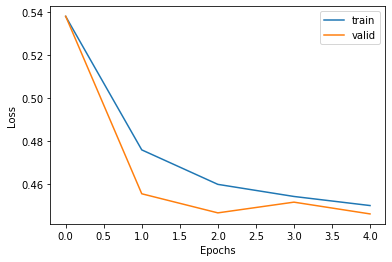

In [68]:
plt.plot(hist['loss'], label="train")
plt.plot(hist['val_loss'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

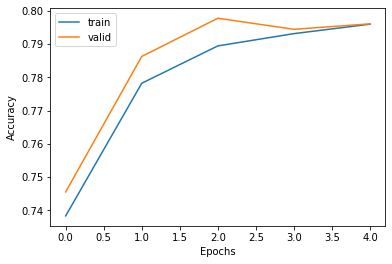

In [69]:
plt.plot(hist['accuracy'], label="train")
plt.plot(hist['val_accuracy'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [70]:
print("max train accuracy: ", np.max(hist['accuracy']))
print("max valid accuracy: ", np.max(hist['val_accuracy']))

max train accuracy:  0.7960149
max valid accuracy:  0.7978011


## E.6. Naïves Bayves

We need to give to computer a probabilistic modelization of the likelihood of the features. The problem is that I have no idea how the feature are distributed in along the different axes once they travelled through UMAP... Let's try Mr Gauss!

Another problem is that Naïves Bayves assumes that the feature are independant which is of course not the case. But, that it a problem every time you use NB, and it still give reasonable results.

In [218]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

maxi1=X_train.shape[0] #To test the complexity of the algo but finally all the training set
#maxi1=1000
maxi2=1000 #Size of the testing set

gnb = GaussianNB()
gnb.fit(X_train[0:maxi1,], y_train[0:maxi1,].reshape(-1))

GaussianNB(priors=None, var_smoothing=1e-09)

In [219]:
ypred = gnb.predict(X_test[0:maxi2,])

In [220]:
resultat=np.zeros(ypred.shape)
for i in range(ypred.shape[0]):
    if (ypred[i]==y_test[i,0]): resultat[i]=1
print("Accuracy Naïves Bayves",maxi1,"data in the training set :",np.mean(resultat))

Accuracy Naïves Bayves 561546 data in the training set : 0.631


Accuracy Naïves Bayves 1000 data in the training set (Gaussian proba) : 0.615
Accuracy Naïves Bayves 5000 data in the training set (Gaussian proba) : 0.627
Accuracy Naïves Bayves 100000 data in the training set (Gaussian proba) : 0.632
Accuracy Naïves Bayves 561546 data in the training set (Gaussian proba) : 0.631
Accuracy Naïves Bayves 561546 data in the training set (Bernouilly proba): 0.589

Well, no big surprise, this does not work!

### CONCLUSION so far : the KNN algorithm seems to give good results. The random forest is even better (by 4 or 5%) but the computation is slow. The KNN speed is quite high and we can test the other features on the nodes and maybe on the words with KNN (and maybe with a random forest - to be tested). Once we will be happy the the features and get a good result with the KNN algorithm, we will try complex RN to improve.

# F. Our best model

## F.1. Build together the best features we have

In [72]:
#PREPARE COMPLEX MODEL (vector of size 869)
X = []
y = []
add_sym = False # Set to true if you want to had symetrical data non present in G
text_emb = vecs_text
node_emb = vecs_nodes

it = 0
with open("training.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        n1, n2 = line[0], line[1]
#         sim_text = similarity(text_emb[n1], text_emb[n2])
        X.append([
            *Node_umap[nid_to_index[n1]], DG.in_degree[n1], DG.out_degree[n1], 
            *node_emb[n1], 
            *Node_umap[nid_to_index[n2]], DG.in_degree[n2], DG.out_degree[n2],
            *node_emb[n2],
            get_jc(G, n1, n2),
            *text_emb[n1],
            *text_emb[n2]])
        if line[2] == "1":
            y.append(1.0)
            it += 1
            if toy and it >= it_toy_limit:
                break
        else:
            y.append(0.0)
                  
        if add_sym and not(G.has_edge(n2, n1)):
            X.append([
                *Node_umap[nid_to_index[n2]], DG.in_degree[n2], DG.out_degree[n2],
                *node_emb[n2], 
                *Node_umap[nid_to_index[n1]], DG.in_degree[n1], DG.out_degree[n1],
                *node_emb[n1], 
                0.0,
                *text_emb[n2],
                *text_emb[n1]])
            y.append(0.0)
                          
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y, axis=1)

453797it [12:41, 595.57it/s] 


NameError: name 'y_complex' is not defined

In [74]:
print("shape X: ", np.shape(X))
print("shape y: ", np.shape(y))
# I turn off the symmetrie to save time

shape X:  (453797, 867)
shape y:  (453797, 1)


### Preprocessing

In [ ]:
preprocessor = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
        ('stdscaler', StandardScaler()),
    ])

X = preprocessor.fit_transform(X)

### Train Validation Split¶

In [22]:
prop_split = 0.10
if prop_split > 0:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=prop_split, random_state=42)
else:
    X_train, y_train = X, y

X_train, X_test, y_train, y_test = train_test_split(X_complex , y_complex, test_size=0.10, random_state=random_state)

## F.2. Last test before complex NN : KNN on the 869 dimensions

In [34]:
#X_train2=X_train-np.mean(X_train,axis=0)
#X_train3=X_train2
#X_test2 =X_test -np.mean(X_train,axis=0)
#X_test3=X_test2

In [35]:
#for i in range(X_train.shape[1]):
#    X_train3[:,i]=X_train2[:,i]/np.std(X_train,axis=0)[i]
#    X_test3 [:,i]=X_test2[:,i]/np.std(X_train,axis=0)[i]

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train.reshape(-1)) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [48]:
ypred=knn.predict(X_test[0:1000]) #Linéaire en la taille ; pas la peine de tout prendre

In [49]:
resultat=np.zeros(ypred.shape)
for i in range(ypred.shape[0]):
    if (ypred[i]==y_test[i,0]): resultat[i]=1
print("Accuracy KNN : ",np.mean(1000*resultat)/1000)

Accuracy KNN :  0.897


## F.3. RNN on the complex model

In [83]:
def vador_model():
    N = 64
    size_emb = nc + 2
    size_n2v_emb = 128
    size_text_emb = 300
    nunits = [N] * 6
    dropout_rate = 0.1
    
    inpt = tf.keras.layers.Input((np.shape(X_train)[1],))
    
    slice_n1 = inpt[:,:size_emb]
    slice_n2v_n1 = inpt[:, size_emb:size_emb+size_n2v_emb]
    slice_n2 = inpt[:,size_emb+size_n2v_emb:size_emb+size_n2v_emb+size_emb]
    slice_n2v_n2 = inpt[:, size_emb+size_n2v_emb+size_emb:size_emb+size_n2v_emb+size_emb+size_n2v_emb]
    slice_jc = inpt[:, size_emb+size_n2v_emb+size_emb+size_n2v_emb:size_emb+size_n2v_emb+size_emb+size_n2v_emb+1]
    cursor = size_emb+size_n2v_emb+size_emb+size_n2v_emb+1
#     slice_sim_text = inpt[:, size_emb+size_n2v_emb+size_emb+size_n2v_emb+1:]
    slice_t_n1 = inpt[:, cursor:cursor+size_text_emb]
    slice_t_n2 = inpt[:, cursor+size_text_emb:cursor+size_text_emb*2]
    
    #UMAP EMBEDDINGS
    l_dense1 = tf.keras.layers.Dense(nunits[0], activation='relu')
    l_dropout1 = tf.keras.layers.Dropout(dropout_rate)
    l_dense2 = tf.keras.layers.Dense(nunits[1], activation='relu')
    l_dropout2 = tf.keras.layers.Dropout(dropout_rate)
    l_dense3 = tf.keras.layers.Dense(nunits[2], activation='relu')
    l_dropout3 = tf.keras.layers.Dropout(dropout_rate)
    
    sub_n1_1 = l_dense1(slice_n1)
    sub_n1_do_1 = l_dropout1(sub_n1_1)
    sub_n1_2 = l_dense2(sub_n1_do_1)
    sub_n1_do_2 = l_dropout2(sub_n1_2)
    sub_n1_3 = l_dense3(sub_n1_do_2)
    sub_n1_do_3 = l_dropout3(sub_n1_3)
    
    sub_n2_1 = l_dense1(slice_n2)
    sub_n2_do_1 = l_dropout1(sub_n2_1)
    sub_n2_2 = l_dense2(sub_n2_do_1)
    sub_n2_do_2 = l_dropout2(sub_n2_2)
    sub_n2_3 = l_dense3(sub_n2_do_2)
    sub_n2_do_3 = l_dropout3(sub_n2_3)
    
    add_emb1 = tf.keras.layers.Concatenate()([sub_n1_do_3, sub_n2_do_3])
    add_emb1 = tf.keras.layers.Dense(nunits[0], activation='relu')(add_emb1)
    add_emb1 = tf.keras.layers.Dropout(dropout_rate)(add_emb1)
    
    # N2V EMBEDDINGS
    n2v_dense1 = tf.keras.layers.Dense(nunits[0], activation='relu')
    n2v_dropout1 = tf.keras.layers.Dropout(dropout_rate)
    n2v_dense2 = tf.keras.layers.Dense(nunits[1], activation='relu')
    n2v_dropout2 = tf.keras.layers.Dropout(dropout_rate)
    n2v_dense3 = tf.keras.layers.Dense(nunits[2], activation='relu')
    n2v_dropout3 = tf.keras.layers.Dropout(dropout_rate)
    
    sub_n1_1 = n2v_dense1(slice_n2v_n1)
    sub_n1_do_1 = n2v_dropout1(sub_n1_1)
    sub_n1_2 = n2v_dense2(sub_n1_do_1)
    sub_n1_do_2 = n2v_dropout2(sub_n1_2)
    sub_n1_3 = n2v_dense3(sub_n1_do_2)
    sub_n1_do_3 = n2v_dropout3(sub_n1_3)
    
    sub_n2_1 = n2v_dense1(slice_n2v_n2)
    sub_n2_do_1 = n2v_dropout1(sub_n2_1)
    sub_n2_2 = n2v_dense2(sub_n2_do_1)
    sub_n2_do_2 = n2v_dropout2(sub_n2_2)
    sub_n2_3 = n2v_dense3(sub_n2_do_2)
    sub_n2_do_3 = n2v_dropout3(sub_n2_3)
    
    add_n2v = tf.keras.layers.Concatenate()([sub_n1_do_3, sub_n2_do_3])
    add_n2v = tf.keras.layers.Dense(nunits[0], activation='relu')(add_n2v)
    add_n2v = tf.keras.layers.Dropout(dropout_rate)(add_n2v)
    
    # W2V EMBEDDINGS
    n2v_dense1 = tf.keras.layers.Dense(nunits[0], activation='relu')
    n2v_dropout1 = tf.keras.layers.Dropout(dropout_rate)
    n2v_dense2 = tf.keras.layers.Dense(nunits[1], activation='relu')
    n2v_dropout2 = tf.keras.layers.Dropout(dropout_rate)
    n2v_dense3 = tf.keras.layers.Dense(1, activation='sigmoid')
    n2v_dropout3 = tf.keras.layers.Dropout(dropout_rate)
    
    sub_n1_1 = n2v_dense1(slice_t_n1)
    sub_n1_do_1 = n2v_dropout1(sub_n1_1)
    sub_n1_2 = n2v_dense2(sub_n1_do_1)
    sub_n1_do_2 = n2v_dropout2(sub_n1_2)
    sub_n1_3 = n2v_dense3(sub_n1_do_2)
    sub_n1_do_3 = n2v_dropout3(sub_n1_3)
    
    sub_n2_1 = n2v_dense1(slice_t_n2)
    sub_n2_do_1 = n2v_dropout1(sub_n2_1)
    sub_n2_2 = n2v_dense2(sub_n2_do_1)
    sub_n2_do_2 = n2v_dropout2(sub_n2_2)
    sub_n2_3 = n2v_dense3(sub_n2_do_2)
    sub_n2_do_3 = n2v_dropout3(sub_n2_3)
    
    add_w2v = tf.keras.layers.Add()([sub_n1_do_3, sub_n2_do_3])
    
    sub_jc_1 = tf.keras.layers.Dense(8, activation='relu')(slice_jc)
    sub_jc_2 = tf.keras.layers.Dense(8, activation='relu')(sub_jc_1)
    sub_jc_3 = tf.keras.layers.Dense(8, activation='relu')(sub_jc_2)
    
#     sub_st_1 = tf.keras.layers.Dense(8, activation='relu')(slice_sim_text)
#     sub_st_2 = tf.keras.layers.Dense(8, activation='relu')(sub_st_1)
#     sub_st_3 = tf.keras.layers.Dense(8, activation='relu')(sub_st_2)
    
    concat = tf.keras.layers.Concatenate()([add_emb1, add_n2v, add_w2v, sub_jc_3])
    
    dense1 = tf.keras.layers.Dense(nunits[3], activation='relu')(concat)
    dense1 = tf.keras.layers.Dropout(dropout_rate)(dense1)
    dense2 = tf.keras.layers.Dense(nunits[4], activation='relu')(dense1)
    dense2 = tf.keras.layers.Dropout(dropout_rate)(dense2)
    dense3 = tf.keras.layers.Dense(nunits[5], activation='relu')(dense2)
    dense3 = tf.keras.layers.Dropout(dropout_rate)(dense3)
    
    out = tf.keras.layers.Dense(1, activation='sigmoid')(dense3)
    
    model = tf.keras.Model(inputs=[inpt], outputs=[out])
    return model

model = vador_model()

NameError: name 'X_train' is not defined

In [84]:
model.summary()

NameError: name 'model' is not defined

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

In [ ]:
lr = 0.001
epochs = 10
batch_size = 32

In [ ]:
# opt = tf.keras.optimizers.RMSprop(lr=lr, rho=0.9)
opt = tf.keras.optimizers.Adam(lr=lr)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 5 and epoch < 10:
        return 1e-4
    else:
        return 1e-5

In [ ]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [ ]:
weights_filepath = "weights.h5"

monitor = "val_acc" if prop_split > 0 else "acc"

callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=weights_filepath,
        monitor=monitor,
        mode='max',
        save_weights_only=True,
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:
if prop_split > 0:
    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
else:
    hist = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

In [ ]:
hist = hist.history

In [ ]:
plt.plot(hist['loss'], label="train")
if prop_split > 0:
    plt.plot(hist['val_loss'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(hist['acc'], label="train")
if prop_split > 0:
    plt.plot(hist['val_acc'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print("max train accuracy: ", np.max(hist['acc']))
if prop_split > 0:
    print("max valid accuracy: ", np.max(hist['val_acc']))

### Prediction on train data¶

In [ ]:
model.load_weights(weights_filepath)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

In [ ]:
thresholds = np.linspace(0.3, 0.7, 30)
accl_train = []
accl_valid = []
f1l_train = []
f1l_valid = []
for thresh in thresholds:
    predictions = (y_pred_train >= thresh).astype(int).flatten()
    acc = np.sum(predictions == y_train.flatten()) / len(predictions)
    f1s = f1_score(predictions, y_train.flatten())
    accl_train.append(acc)
    f1l_train.append(f1s)
    
    predictions = (y_pred_valid >= thresh).astype(int).flatten()
    acc = np.sum(predictions == y_valid.flatten()) / len(predictions)
    f1s = f1_score(predictions, y_valid.flatten())
    accl_valid.append(acc)
    f1l_valid.append(f1s)

plt.plot(thresholds, accl_train, "b-", label="train")
plt.plot(thresholds, accl_valid, "r-", label="valid")
plt.ylabel("Accuracy")
plt.xlabel("Thresholds")
plt.legend()
plt.show()

plt.plot(thresholds, f1l_train, "b-", label="train")
plt.plot(thresholds, f1l_valid, "r-", label="valid")
plt.ylabel("F1")
plt.xlabel("Thresholds")
plt.legend()
plt.show()

imax = np.argmax(f1l_valid)
threshold = thresholds[imax]
predictions = (y_pred_valid >= threshold).astype(int).flatten()
f1s = f1_score(predictions, y_valid.flatten())

print(f"Best accuracy: {accl_valid[imax]} for threshold={threshold}")
print(f"F1 score: {f1s}")

In [86]:
### Prediction on test data

In [ ]:
Xt = []

with open("testing.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        n1, n2 = line[0], line[1]
#         sim_text = similaIrity(text_emb[n1], text_emb[n2])
#         Xt.append([*embedding[nid_to_index[n1]], G.degree[n1], *embedding[nid_to_index[n2]], G.degree[n2], get_jc(G, n1, n2)])
        Xt.append([
            *embedding[nid_to_index[n1]], DG.in_degree[n1], DG.out_degree[n1],
            *node_emb[n1],
            *embedding[nid_to_index[n2]], DG.in_degree[n2], DG.out_degree[n2],
            *node_emb[n2],
            get_jc(G, n1, n2),
#             sim_text,
            *text_emb[n1], 
            *text_emb[n2]])
        
Xt = np.array(Xt)

In [ ]:
Xt = preprocessor.transform(Xt)

In [ ]:
y_pred = model.predict(Xt)

In [ ]:
predictions = (y_pred >= threshold).astype(int).flatten()
acc = 0
with open("testing.txt", "r") as f:
    for i, line in tqdm(enumerate(f)):
        line = line.split()
        n1, n2 = line[0], line[1]
        if (G.degree(n1) == 0 or G.degree(n2) == 0) and predictions[i]:
            predictions[i] == 0
            acc += 1
print(acc)

# G. SAVE PREDICTION FOR KAGGLE

In [239]:
y_pred = rf.predict(Xt)
y_pred[y_pred>0.5]=1
y_pred[y_pred<=0.5]=0

In [240]:
print(y_pred.shape)
print(y_pred[0:100])

(113450,)
[1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 0.]


In [241]:
def save_predictions(y, filename):
    """
    Save predictions y (0, 1 values) to a csv
    """
    predictions = zip(range(len(y)), y)
    # Write the output in the format required by Kaggle
    with open(filename,'w') as pred:
        csv_out = csv.writer(pred)
        csv_out.writerow(['id','predicted'])
        for row in predictions:
            csv_out.writerow(row) 
    print('Saved predictions to', filename)

In [242]:
threshold = 0.5
predictions = (y_pred >= threshold).astype(int).flatten()
save_predictions(predictions, 'out.csv')

Saved predictions to out.csv


In [243]:
y_pred.shape

(113450,)